In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from keras import backend as K
K.tensorflow_backend._get_available_gpus()


cuda


['/job:localhost/replica:0/task:0/device:GPU:0']

## Q1

In [3]:
torch.__version__

'1.1.0'

In [4]:
dataset_root_dir = ''

## Q2

In [5]:
class ShipsDataset(td.Dataset):

    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(ShipsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, mode)

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "ShipsDataset(mode={}, image_size={})".format(self.mode, self.image_size)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.data.iloc[idx]['file_path'])
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.RandomAffine(45),#delete to get rid of augmentation
            tv.transforms.RandomHorizontalFlip(),#delete to get rid of augmentation
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
            ])
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d

    def number_of_classes(self):
        return self.data['class'].max() + 1

## Q3

1


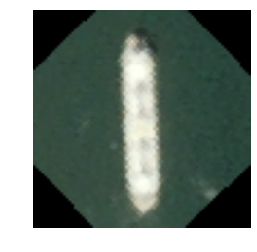

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

train_set = ShipsDataset(dataset_root_dir)
x, d = train_set[2701]
myimshow(x)
print(d)


## Q4

In [7]:
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True, pin_memory=True)
print(len(data_loader))

225


Number of mini-batches: 250, which is 4000/16

The advantage of using pin_memory is that it makes data transfer from CPU memory to GPU memory much faster.

## Q5

tensor(0)
tensor(0)
tensor(0)
tensor(0)


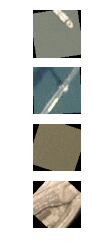

In [8]:
count = 0
for inputs, labels in data_loader:
    myimshow(inputs[0], plt.subplot(4,1,count+1))
    print(labels[0])
    count += 1
    if count == 4:
        break

In [9]:
val_set = ShipsDataset(dataset_root_dir, mode='val')
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=False, pin_memory=True)

In [10]:
import nntools as nt

class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [11]:
vgg = tv.models.vgg16_bn(pretrained=True)
for name, para in vgg.named_parameters():
    print(name, para.size(), para.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

In [12]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        # COMPLETE
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # COMPLETE
        m = self.features(x)
        f = m.view(16, 25088)
        y = self.classifier(f)
        return y

In [13]:
vgg16transfer_classifier = VGG16Transfer(num_classes=train_set.number_of_classes())
for name, para in vgg16transfer_classifier.named_parameters():
    print(name, para.size(), para.requires_grad)

classifier.6.weight torch.Size([2, 4096]) True
classifier.6.bias torch.Size([2]) True


In [14]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * (1 - loss) # COMPLETE
        return {'loss': loss, 'accuracy': accuracy}

In [15]:
lr = 1e-4
net = VGG16Transfer(train_set.number_of_classes())
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager, perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 (Time: 310.03s)
Epoch 2 (Time: 310.52s)
Epoch 3 (Time: 294.08s)
Epoch 4 (Time: 274.50s)
Epoch 5 (Time: 267.53s)
Epoch 6 (Time: 289.30s)
Epoch 7 (Time: 281.20s)
Epoch 8 (Time: 288.43s)
Epoch 9 (Time: 291.43s)
Epoch 10 (Time: 272.48s)
Epoch 11 (Time: 270.33s)
Epoch 12 (Time: 282.51s)
Epoch 13 (Time: 286.81s)
Epoch 14 (Time: 288.41s)
Epoch 15 (Time: 317.39s)
Epoch 16 (Time: 406.51s)
Epoch 17 (Time: 401.11s)
Epoch 18 (Time: 438.42s)
Epoch 19 (Time: 463.11s)
Epoch 20 (Time: 449.13s)
Finish training for 20 epochs


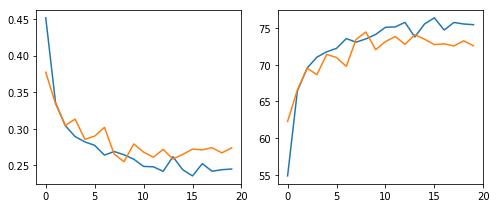

In [16]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="training loss")
    # COMPLETE
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)], label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="evaluation loss")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)], label="evaluation loss")
    plt.tight_layout()
    fig.canvas.draw()
    
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))


In [22]:
print(exp1.history[0])
print(exp1.history[1])


({'loss': 0.4515235282977422, 'accuracy': 54.84764717022578}, {'loss': 0.3771968686580658, 'accuracy': 62.28031313419342})
({'loss': 0.3357132839494281, 'accuracy': 66.42867160505719}, {'loss': 0.3343155109882355, 'accuracy': 66.56844890117645})


Start/Continue training from epoch 20
Epoch 21 (Time: 472.10s)
Epoch 22 (Time: 409.40s)
Epoch 23 (Time: 387.30s)
Epoch 24 (Time: 436.08s)
Epoch 25 (Time: 423.84s)
Finish training for 25 epochs


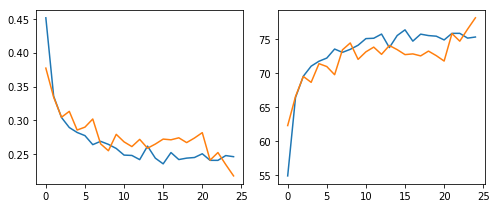

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=25, plot=lambda exp: plot(exp, fig=fig, axes=axes))


Start/Continue training from epoch 30
Epoch 31 (Time: 556.14s)
Epoch 32 (Time: 603.04s)
Epoch 33 (Time: 539.92s)
Epoch 34 (Time: 607.02s)
Epoch 35 (Time: 536.08s)
Epoch 36 (Time: 628.61s)
Epoch 37 (Time: 443.04s)
Epoch 38 (Time: 300.43s)
Epoch 39 (Time: 266.45s)
Epoch 40 (Time: 278.63s)
Finish training for 40 epochs


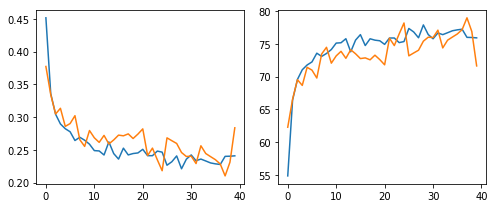

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=40, plot=lambda exp: plot(exp, fig=fig, axes=axes))


In [23]:
# ResNet transfer
resnet = tv.models.resnet18(pretrained = True)
print(resnet)

class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,512)
        y = self.fc(x)
        return y
    
resnet18 = Resnet18Transfer(train_set.number_of_classes())
print(resnet18)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [25]:
lr = 1e-4 # learning rate
net = Resnet18Transfer(train_set.number_of_classes())
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager, perform_validation_during_training=True)



Start/Continue training from epoch 40
Epoch 41 (Time: 719.39s)
Epoch 42 (Time: 389.71s)
Epoch 43 (Time: 556.62s)
Epoch 44 (Time: 613.62s)
Epoch 45 (Time: 535.92s)
Epoch 46 (Time: 558.45s)
Epoch 47 (Time: 726.55s)
Epoch 48 (Time: 309.34s)
Epoch 49 (Time: 314.93s)
Epoch 50 (Time: 308.52s)
Finish training for 50 epochs
{'loss': 0.22632567271590232, 'accuracy': 77.36743272840977}


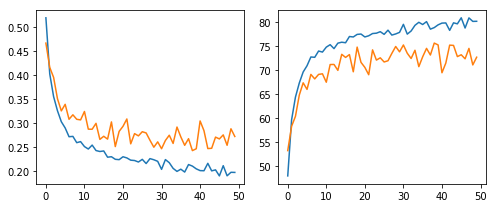

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=50, plot=lambda exp: plot(exp, fig=fig, axes=axes))

print(exp2.evaluate())
